In [1]:
!pip install rank-bm25 sentence-transformers scikit-learn matplotlib --quiet


In [2]:
import os
import json
from dataclasses import dataclass
from typing import List, Dict, Tuple, Set

import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

from rank_bm25 import BM25Okapi
from sentence_transformers import SentenceTransformer


In [3]:
@dataclass
class Document:
    doc_id: str
    text: str


def load_documents(docs_dir: str = "data/docs") -> List[Document]:
    """
    Load all .txt files from docs_dir as Document objects.
    doc_id = filename without extension.
    """
    documents = []
    if not os.path.exists(docs_dir):
        raise FileNotFoundError(f"{docs_dir} does not exist.")
    for fname in os.listdir(docs_dir):
        if not fname.lower().endswith(".txt"):
            continue
        path = os.path.join(docs_dir, fname)
        with open(path, "r", encoding="utf-8") as f:
            text = f.read()
        doc_id = os.path.splitext(fname)[0]
        documents.append(Document(doc_id=doc_id, text=text))
    documents.sort(key=lambda d: d.doc_id)
    print(f"Loaded {len(documents)} documents from {docs_dir}")
    return documents


def load_qa_pairs(path: str = "data/qa_pairs.json") -> List[Dict]:
    """
    Load QA pairs. Each entry:
      - id: str
      - question: str
      - relevant_docs: List[str]
      - difficulty: "easy" | "medium" | "hard"
    """
    if not os.path.exists(path):
        raise FileNotFoundError(f"{path} does not exist.")
    with open(path, "r", encoding="utf-8") as f:
        qa_list = json.load(f)
    print(f"Loaded {len(qa_list)} QA pairs from {path}")
    return qa_list


def build_corpus_and_ids(documents: List[Document]) -> Tuple[List[str], List[str]]:
    corpus = [d.text for d in documents]
    doc_ids = [d.doc_id for d in documents]
    return corpus, doc_ids


In [7]:
import os, json

os.makedirs("data/docs", exist_ok=True)

docs = {
    "doc1_intro_to_rag": """
Title: Introduction to Retrieval-Augmented Generation

Retrieval-Augmented Generation (RAG) is an approach where a generative language
model is connected to an external knowledge base. At query time, a retriever
selects the most relevant documents for the user question. These documents are
then provided as additional context to the generator, which produces an answer
grounded in the retrieved evidence.

RAG is particularly useful when the knowledge base changes frequently, or when
the model must be able to answer questions about niche domains that were not
fully covered during pre-training. Instead of re-training the entire model,
we simply update or extend the underlying document collection.
""",

    "doc2_bm25_vs_dense": """
Title: BM25 and Dense Retrieval Methods

BM25 is a classical ranking function widely used in information retrieval. It
relies on term frequency and inverse document frequency, and works directly on
tokenized text without any learned embeddings. BM25 is simple, robust, and
remains highly competitive for many keyword-style search tasks.

Dense retrieval methods, on the other hand, represent queries and documents as
vectors in a shared embedding space. These embeddings are typically produced by
a neural network, such as a transformer encoder, and similarity is measured
with dot product or cosine similarity. Dense retrievers can capture semantic
similarity beyond exact keyword overlap, but they usually require more compute
and a training phase.
""",

    "doc3_rag_in_agriculture": """
Title: Applications of RAG in Agricultural Knowledge Systems

In agricultural settings, domain experts need quick access to heterogeneous
information sources such as technical reports, regulations, weather bulletins,
and internal best-practice documents. Retrieval-Augmented Generation (RAG) can
be used to build chatbots that answer questions about crop diseases, fertilizer
dosages, or trade regulations by retrieving relevant passages from a curated
corpus of documents.

Compared to a pure retrieval system, a RAG-based assistant can synthesize
information from multiple documents and generate coherent natural language
answers. This reduces the time experts spend searching manually and improves
access to strategic and technical knowledge within the organization.
""",

    "doc4_system_design": """
Title: System Design Considerations for RAG Pipelines

A practical RAG system typically consists of three layers: ingestion, retrieval,
and generation. Ingestion is responsible for parsing raw documents (PDF, HTML,
text) and storing them in a normalized format. The retrieval layer indexes the
documents, using BM25, dense embeddings, or a hybrid of both. The generation
layer is usually a large language model that receives both the query and the
retrieved passages.

When designing such systems, engineers must consider latency, index update
frequency, data privacy constraints, and evaluation methodology. In many cases,
a hybrid retriever that combines BM25 and dense retrieval provides a good
balance between robustness and semantic understanding.
""",

    "doc5_evaluation_metrics": """
Title: Evaluation Metrics for Information Retrieval and RAG

To evaluate retrieval quality, practitioners often rely on metrics such as
Recall@k, Precision@k, and Mean Reciprocal Rank (MRR). Recall@k measures how
often at least one relevant document appears in the top-k retrieved results,
while Precision@k quantifies the fraction of retrieved items that are relevant.

MRR focuses specifically on the rank of the first relevant document, assigning
higher scores when relevant documents are ranked closer to the top. For RAG
systems, offline evaluation of retrievers can be combined with human judgments
of generated answers to obtain a more complete view of system quality.
""",

    "doc6_latency_scaling": """
Title: Latency and Scaling Considerations

RAG systems deployed in production must satisfy strict latency constraints,
especially when integrated into interactive chat interfaces. Users typically
expect a response within a few hundred milliseconds, which limits the number
of documents that can be retrieved and the size of the language model that can
be used for generation.

To scale RAG to large document collections, engineers adopt techniques such as
sharding, approximate nearest neighbor search, and request batching. Caching
popular queries and precomputing representations can further reduce response
times.
""",

    "doc7_security_privacy": """
Title: Security and Privacy in RAG Systems

RAG pipelines often operate over sensitive corporate documents. As a result,
access control and audit logging are critical. The retriever must respect
document-level permissions so that users cannot see content they are not
authorized to access. Moreover, logs of queries and retrieved passages need to
be stored securely and anonymized whenever possible.

From a privacy perspective, it is important to prevent the language model from
memorizing or leaking confidential information. Techniques such as redaction,
on-the-fly de-identification, and private deployment of models can mitigate
some of these risks.
""",

    "doc8_prompt_engineering": """
Title: Prompt Engineering for RAG

Even with a strong retriever, the quality of RAG outputs depends heavily on
prompt design. A typical RAG prompt contains the user question, the retrieved
passages, and explicit instructions such as: 'answer based only on the context'
or 'cite sources in your response'. Carefully crafted prompts can reduce
hallucinations and encourage the model to ask for clarification when the
retrieved evidence is insufficient.

Prompt engineering also involves decisions about how many passages to show, how
they are formatted, and whether the system should generate chain-of-thought
explanations or concise answers.
""",

    "doc9_rag_customer_support": """
Title: RAG for Customer Support

In customer support scenarios, RAG systems can answer questions about product
features, troubleshooting steps, and company policies by retrieving from an
up-to-date knowledge base. Compared to static FAQ pages, a RAG-powered virtual
assistant can handle more diverse queries and adapt to new documents as soon as
they are ingested.

However, support environments are sensitive to incorrect answers. As a result,
organizations often combine RAG with confidence estimation, fallback rules, and
human-in-the-loop review for high-risk requests.
""",

    "doc10_rag_finance": """
Title: RAG in Financial Applications

Financial institutions are exploring RAG to help analysts navigate long
regulatory documents, research reports, and internal risk assessments. In this
domain, strict compliance requirements demand traceable answers and explicit
links back to source documents. The retrieval component must be carefully tuned
to avoid missing critical passages that could change the interpretation of
regulations or risk guidelines.

Latency constraints can also be less strict for research workflows, which
allows the use of larger models and more retrieved documents, but increases
compute costs.
""",

    "doc11_indexing_strategies": """
Title: Indexing Strategies for Large-Scale Corpora

Indexing strategies determine how documents are stored and accessed by the
retriever. BM25 typically relies on inverted indexes, which map terms to the
documents that contain them. Dense retrieval uses vector indexes such as FAISS
or ScaNN, which support approximate nearest neighbor search in high-dimensional
spaces.

Hybrid systems may maintain both an inverted index and a vector index, merging
scores at query time. The choice of index has strong implications for memory
usage, latency, and update frequency.
""",

    "doc12_failure_modes": """
Title: Common Failure Modes of RAG Systems

RAG systems can fail in several characteristic ways. The retriever may miss
critical documents due to vocabulary mismatch or outdated indexes. Even when
relevant passages are retrieved, the generator might ignore them and hallucinate
facts, especially when prompts are poorly designed or when the model has strong
prior beliefs.

Another failure mode involves partial answers: the system returns only a subset
of the necessary information, which can be dangerous in domains such as
medicine or law. Robust evaluation and monitoring are therefore essential to
detect and mitigate these issues.
"""
}

for doc_id, text in docs.items():
    with open(f"data/docs/{doc_id}.txt", "w", encoding="utf-8") as f:
        f.write(text)

qa_pairs = [
    # ---------- EASY ----------
    {"id": "q1", "difficulty": "easy",
     "question": "What is Retrieval-Augmented Generation (RAG)?",
     "relevant_docs": ["doc1_intro_to_rag"]},
    {"id": "q2", "difficulty": "easy",
     "question": "What does BM25 rely on to rank documents?",
     "relevant_docs": ["doc2_bm25_vs_dense"]},
    {"id": "q3", "difficulty": "easy",
     "question": "Which layer parses raw PDFs and HTML in a RAG pipeline?",
     "relevant_docs": ["doc4_system_design"]},
    {"id": "q4", "difficulty": "easy",
     "question": "Which metric focuses on the rank of the first relevant document?",
     "relevant_docs": ["doc5_evaluation_metrics"]},
    {"id": "q5", "difficulty": "easy",
     "question": "Which component must respect document-level permissions in RAG?",
     "relevant_docs": ["doc7_security_privacy"]},
    {"id": "q6", "difficulty": "easy",
     "question": "In which domain can RAG assist analysts reading regulations and research reports?",
     "relevant_docs": ["doc10_rag_finance"]},
    {"id": "q7", "difficulty": "easy",
     "question": "Which document discusses using RAG for crop disease and fertilizer questions?",
     "relevant_docs": ["doc3_rag_in_agriculture"]},
    {"id": "q8", "difficulty": "easy",
     "question": "Which document describes RAG for answering customer questions about products and policies?",
     "relevant_docs": ["doc9_rag_customer_support"]},

    # ---------- MEDIUM ----------
    {"id": "q9", "difficulty": "medium",
     "question": "Why can RAG be preferable to retraining a language model when new documents arrive?",
     "relevant_docs": ["doc1_intro_to_rag"]},
    {"id": "q10", "difficulty": "medium",
     "question": "Which retrieval approach can capture semantic similarity beyond exact keyword overlap?",
     "relevant_docs": ["doc2_bm25_vs_dense"]},
    {"id": "q11", "difficulty": "medium",
     "question": "How can RAG-based assistants reduce the time agricultural experts spend manually searching for information?",
     "relevant_docs": ["doc3_rag_in_agriculture"]},
    {"id": "q12", "difficulty": "medium",
     "question": "What are the three typical layers of a practical RAG system?",
     "relevant_docs": ["doc4_system_design"]},
    {"id": "q13", "difficulty": "medium",
     "question": "Which metrics could you use to report how often relevant documents appear near the top of the ranking?",
     "relevant_docs": ["doc5_evaluation_metrics"]},
    {"id": "q14", "difficulty": "medium",
     "question": "What techniques can help scale RAG to very large document collections while keeping latency under control?",
     "relevant_docs": ["doc6_latency_scaling"]},
    {"id": "q15", "difficulty": "medium",
     "question": "How can organizations prevent RAG systems from leaking confidential information?",
     "relevant_docs": ["doc7_security_privacy"]},
    {"id": "q16", "difficulty": "medium",
     "question": "Why is it important to instruct the model to answer only based on retrieved context in the prompt?",
     "relevant_docs": ["doc8_prompt_engineering"]},
    {"id": "q17", "difficulty": "medium",
     "question": "What additional safeguards might customer support teams add around a RAG assistant to avoid harmful responses?",
     "relevant_docs": ["doc9_rag_customer_support"]},
    {"id": "q18", "difficulty": "medium",
     "question": "Why are traceable answers with explicit links to source documents especially important in finance?",
     "relevant_docs": ["doc10_rag_finance"]},

    # ---------- HARD ----------
    {"id": "q19", "difficulty": "hard",
     "question": "Which methods go beyond simple term matching and instead compare continuous representations of queries and documents?",
     "relevant_docs": ["doc2_bm25_vs_dense", "doc11_indexing_strategies"]},
    {"id": "q20", "difficulty": "hard",
     "question": "When building a large-scale RAG index, which kinds of data structures might you use for lexical and vector-based retrieval?",
     "relevant_docs": ["doc11_indexing_strategies"]},
    {"id": "q21", "difficulty": "hard",
     "question": "For agricultural question-answering, which modules of a RAG system must be engineered to handle heterogeneous reports and regulations?",
     "relevant_docs": ["doc3_rag_in_agriculture", "doc4_system_design"]},
    {"id": "q22", "difficulty": "hard",
     "question": "In a chat interface where users expect sub-second responses, which aspects of the RAG pipeline become bottlenecks?",
     "relevant_docs": ["doc4_system_design", "doc6_latency_scaling"]},
    {"id": "q23", "difficulty": "hard",
     "question": "What types of failures can occur when the retriever misses key passages or the generator ignores retrieved evidence?",
     "relevant_docs": ["doc12_failure_modes"]},
    {"id": "q24", "difficulty": "hard",
     "question": "Which documents describe problems where the model gives only partial answers or hallucinates unsupported statements?",
     "relevant_docs": ["doc12_failure_modes", "doc8_prompt_engineering"]},
    {"id": "q25", "difficulty": "hard",
     "question": "In sensitive domains like finance and internal corporate data, which concerns arise around access control and compliance for RAG?",
     "relevant_docs": ["doc7_security_privacy", "doc10_rag_finance"]},
    {"id": "q26", "difficulty": "hard",
     "question": "If you wanted to evaluate not just whether relevant documents are retrieved but also how the generator uses them, which documents discuss such evaluation ideas?",
     "relevant_docs": ["doc5_evaluation_metrics", "doc12_failure_modes"]},
    {"id": "q27", "difficulty": "hard",
     "question": "What combination of retrieval approaches and indexing strategies could provide a good trade-off between robustness and semantic understanding?",
     "relevant_docs": ["doc2_bm25_vs_dense", "doc11_indexing_strategies", "doc4_system_design"]},
    {"id": "q28", "difficulty": "hard",
     "question": "For a customer-support RAG system, which issues must be considered around latency, safety, and user trust?",
     "relevant_docs": ["doc6_latency_scaling", "doc7_security_privacy", "doc9_rag_customer_support"]},
    {"id": "q29", "difficulty": "hard",
     "question": "Which parts of the RAG pipeline are most likely to cause users to lose trust if they fail silently?",
     "relevant_docs": ["doc4_system_design", "doc12_failure_modes"]},
    {"id": "q30", "difficulty": "hard",
     "question": "Across the described use cases, which texts emphasize the importance of human oversight or human-in-the-loop processes?",
     "relevant_docs": ["doc9_rag_customer_support", "doc10_rag_finance", "doc12_failure_modes"]},
    {"id": "q31", "difficulty": "hard",
     "question": "Where can you find a discussion of how many passages to show and how to format them in the prompt?",
     "relevant_docs": ["doc8_prompt_engineering"]},
    {"id": "q32", "difficulty": "hard",
     "question": "Which documents describe trade-offs between latency constraints and the ability to use larger models or more retrieved passages?",
     "relevant_docs": ["doc6_latency_scaling", "doc10_rag_finance"]}
]

with open("data/qa_pairs.json", "w", encoding="utf-8") as f:
    json.dump(qa_pairs, f, indent=2)

print(f"Created {len(docs)} documents and {len(qa_pairs)} QA pairs ✅")


Created 12 documents and 32 QA pairs ✅


In [8]:
def simple_tokenize(text: str) -> List[str]:
    return text.lower().split()


class BM25Retriever:
    """
    BM25 keyword-based retriever using rank-bm25.
    """

    def __init__(self, corpus: List[str], doc_ids: List[str]):
        self.doc_ids = doc_ids
        self.tokenized_corpus = [simple_tokenize(doc) for doc in corpus]
        self.bm25 = BM25Okapi(self.tokenized_corpus)

    def search(self, query: str, k: int = 5):
        tokenized_query = simple_tokenize(query)
        scores = self.bm25.get_scores(tokenized_query)
        ranked = sorted(
            zip(self.doc_ids, scores),
            key=lambda x: x[1],
            reverse=True,
        )
        return ranked[:k]


In [9]:
class DenseRetriever:
    """
    Dense embedding-based retriever using sentence-transformers.
    """

    def __init__(self, corpus: List[str], doc_ids: List[str],
                 model_name: str = "all-MiniLM-L6-v2"):
        self.doc_ids = doc_ids
        print(f"Loading sentence-transformers model: {model_name}")
        self.model = SentenceTransformer(model_name)
        print("Encoding documents...")
        self.doc_embeddings = self.model.encode(
            corpus, convert_to_numpy=True, show_progress_bar=True
        )

    def search(self, query: str, k: int = 5):
        query_emb = self.model.encode([query], convert_to_numpy=True)
        sims = cosine_similarity(query_emb, self.doc_embeddings)[0]
        ranked = sorted(
            zip(self.doc_ids, sims),
            key=lambda x: x[1],
            reverse=True,
        )
        return ranked[:k]

    def scores_for_all(self, query: str) -> np.ndarray:
        query_emb = self.model.encode([query], convert_to_numpy=True)
        sims = cosine_similarity(query_emb, self.doc_embeddings)[0]
        return sims


In [10]:
class HybridRetriever:
    """
    Simple hybrid retriever combining BM25 and dense similarities.

    hybrid_score = alpha * bm25_norm + (1 - alpha) * dense_norm
    """

    def __init__(self, corpus: List[str], doc_ids: List[str], dense_retriever: DenseRetriever):
        self.doc_ids = doc_ids
        self.bm25 = BM25Retriever(corpus, doc_ids)
        self.dense = dense_retriever

    def search(self, query: str, k: int = 5, alpha: float = 0.5):
        tokenized_query = simple_tokenize(query)
        bm25_scores = self.bm25.bm25.get_scores(tokenized_query)
        dense_scores = self.dense.scores_for_all(query)

        def norm(scores):
            scores = scores.astype("float32")
            if scores.max() - scores.min() < 1e-8:
                return np.zeros_like(scores)
            return (scores - scores.min()) / (scores.max() - scores.min())

        bm25_norm = norm(bm25_scores)
        dense_norm = norm(dense_scores)
        hybrid = alpha * bm25_norm + (1.0 - alpha) * dense_norm

        ranked = sorted(
            zip(self.doc_ids, hybrid),
            key=lambda x: x[1],
            reverse=True,
        )
        return ranked[:k]


In [11]:
def compute_recall_at_k(rankings: List[List[str]],
                        relevant_sets: List[Set[str]],
                        k: int) -> float:
    recalls = []
    for docs, rel in zip(rankings, relevant_sets):
        topk = docs[:k]
        hit = len(rel.intersection(topk)) > 0
        recalls.append(1.0 if hit else 0.0)
    return float(np.mean(recalls))


def compute_precision_at_k(rankings: List[List[str]],
                           relevant_sets: List[Set[str]],
                           k: int) -> float:
    precisions = []
    for docs, rel in zip(rankings, relevant_sets):
        topk = docs[:k]
        hits = len(rel.intersection(topk))
        precisions.append(hits / max(len(topk), 1))
    return float(np.mean(precisions))


def compute_mrr_at_k(rankings: List[List[str]],
                     relevant_sets: List[Set[str]],
                     k: int) -> float:
    mrrs = []
    for docs, rel in zip(rankings, relevant_sets):
        rr = 0.0
        for rank, doc_id in enumerate(docs[:k], start=1):
            if doc_id in rel:
                rr = 1.0 / rank
                break
        mrrs.append(rr)
    return float(np.mean(mrrs))


def summarize_metrics(name: str, rankings: List[List[str]], relevant_sets: List[Set[str]]):
    print(f"=== {name} ===")
    for k in [1, 3, 5]:
        r = compute_recall_at_k(rankings, relevant_sets, k)
        p = compute_precision_at_k(rankings, relevant_sets, k)
        mrr = compute_mrr_at_k(rankings, relevant_sets, k)
        print(f"k={k}: Recall={r:.3f}, Precision={p:.3f}, MRR={mrr:.3f}")


In [12]:
documents = load_documents("data/docs")
qa_pairs = load_qa_pairs("data/qa_pairs.json")
corpus, doc_ids = build_corpus_and_ids(documents)

questions = [qa["question"] for qa in qa_pairs]
relevant_sets = [set(qa["relevant_docs"]) for qa in qa_pairs]
difficulties = [qa["difficulty"] for qa in qa_pairs]

print(f"Number of documents: {len(documents)}")
print(f"Number of QA pairs: {len(qa_pairs)}")

dense = DenseRetriever(corpus, doc_ids, model_name="all-MiniLM-L6-v2")
bm25 = BM25Retriever(corpus, doc_ids)
hybrid = HybridRetriever(corpus, doc_ids, dense_retriever=dense)


Loaded 12 documents from data/docs
Loaded 32 QA pairs from data/qa_pairs.json
Number of documents: 12
Number of QA pairs: 32
Loading sentence-transformers model: all-MiniLM-L6-v2


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Encoding documents...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

In [13]:
rankings_bm25 = []
rankings_dense = []
rankings_hybrid = []

for q in questions:
    bm25_res = bm25.search(q, k=10)
    dense_res = dense.search(q, k=10)
    hybrid_res = hybrid.search(q, k=10, alpha=0.5)

    rankings_bm25.append([doc_id for doc_id, _ in bm25_res])
    rankings_dense.append([doc_id for doc_id, _ in dense_res])
    rankings_hybrid.append([doc_id for doc_id, _ in hybrid_res])

summarize_metrics("BM25", rankings_bm25, relevant_sets)
summarize_metrics("Dense", rankings_dense, relevant_sets)
summarize_metrics("Hybrid (alpha=0.5)", rankings_hybrid, relevant_sets)


=== BM25 ===
k=1: Recall=0.906, Precision=0.906, MRR=0.906
k=3: Recall=0.938, Precision=0.354, MRR=0.922
k=5: Recall=0.969, Precision=0.250, MRR=0.928
=== Dense ===
k=1: Recall=0.844, Precision=0.844, MRR=0.844
k=3: Recall=0.969, Precision=0.417, MRR=0.906
k=5: Recall=1.000, Precision=0.269, MRR=0.914
=== Hybrid (alpha=0.5) ===
k=1: Recall=0.906, Precision=0.906, MRR=0.906
k=3: Recall=0.969, Precision=0.396, MRR=0.932
k=5: Recall=1.000, Precision=0.263, MRR=0.939


In [14]:
def filter_by_difficulty(rankings, relevant_sets, difficulties, target_diff: str):
    idxs = [i for i, d in enumerate(difficulties) if d == target_diff]
    r_sub = [rankings[i] for i in idxs]
    rel_sub = [relevant_sets[i] for i in idxs]
    return r_sub, rel_sub

for diff in ["easy", "medium", "hard"]:
    print(f"\n--- Difficulty: {diff} ---")
    for name, ranks in [
        ("BM25", rankings_bm25),
        ("Dense", rankings_dense),
        ("Hybrid", rankings_hybrid),
    ]:
        r_sub, rel_sub = filter_by_difficulty(ranks, relevant_sets, difficulties, diff)
        if not r_sub:
            continue
        r = compute_recall_at_k(r_sub, rel_sub, k=1)
        mrr = compute_mrr_at_k(r_sub, rel_sub, k=3)
        print(f"{name}: Recall@1={r:.3f}, MRR@3={mrr:.3f}")



--- Difficulty: easy ---
BM25: Recall@1=0.875, MRR@3=0.938
Dense: Recall@1=0.875, MRR@3=0.938
Hybrid: Recall@1=0.875, MRR@3=0.917

--- Difficulty: medium ---
BM25: Recall@1=0.900, MRR@3=0.900
Dense: Recall@1=0.800, MRR@3=0.850
Hybrid: Recall@1=0.900, MRR@3=0.900

--- Difficulty: hard ---
BM25: Recall@1=0.929, MRR@3=0.929
Dense: Recall@1=0.857, MRR@3=0.929
Hybrid: Recall@1=0.929, MRR@3=0.964


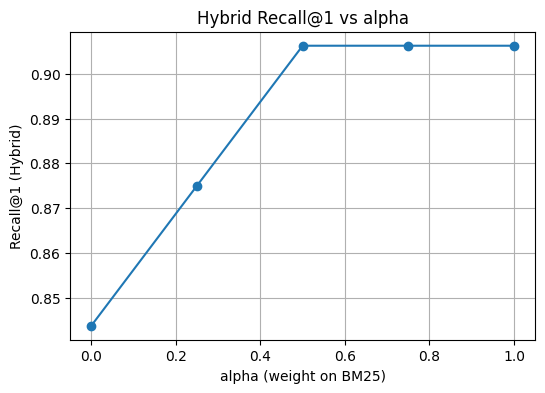

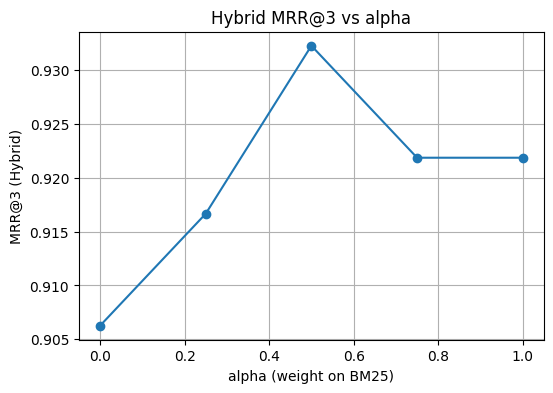

([0.84375, 0.875, 0.90625, 0.90625, 0.90625],
 [0.90625, 0.9166666666666666, 0.9322916666666666, 0.921875, 0.921875])

In [15]:
alphas = [0.0, 0.25, 0.5, 0.75, 1.0]  # 0 = pure dense, 1 = pure BM25

recalls_alpha = []
mrr_alpha = []

for alpha in alphas:
    rankings_h = []
    for q in questions:
        res = hybrid.search(q, k=10, alpha=alpha)
        rankings_h.append([doc_id for doc_id, _ in res])
    recalls_alpha.append(compute_recall_at_k(rankings_h, relevant_sets, k=1))
    mrr_alpha.append(compute_mrr_at_k(rankings_h, relevant_sets, k=3))

plt.figure(figsize=(6,4))
plt.plot(alphas, recalls_alpha, marker="o")
plt.xlabel("alpha (weight on BM25)")
plt.ylabel("Recall@1 (Hybrid)")
plt.title("Hybrid Recall@1 vs alpha")
plt.grid(True)
plt.show()

plt.figure(figsize=(6,4))
plt.plot(alphas, mrr_alpha, marker="o")
plt.xlabel("alpha (weight on BM25)")
plt.ylabel("MRR@3 (Hybrid)")
plt.title("Hybrid MRR@3 vs alpha")
plt.grid(True)
plt.show()

recalls_alpha, mrr_alpha


In [16]:
os.makedirs("results", exist_ok=True)

metrics = {}
for name, ranks in [
    ("bm25", rankings_bm25),
    ("dense", rankings_dense),
    ("hybrid_alpha0.5", rankings_hybrid),
]:
    metrics[name] = {}
    for k in [1, 3, 5]:
        metrics[name][f"recall@{k}"] = compute_recall_at_k(ranks, relevant_sets, k)
        metrics[name][f"precision@{k}"] = compute_precision_at_k(ranks, relevant_sets, k)
        metrics[name][f"mrr@{k}"] = compute_mrr_at_k(ranks, relevant_sets, k)

metrics["hybrid_alpha_sweep"] = {
    "alphas": alphas,
    "recall@1": recalls_alpha,
    "mrr@3": mrr_alpha,
}

with open("results/metrics.json", "w", encoding="utf-8") as f:
    json.dump(metrics, f, indent=2)

metrics


{'bm25': {'recall@1': 0.90625,
  'precision@1': 0.90625,
  'mrr@1': 0.90625,
  'recall@3': 0.9375,
  'precision@3': 0.35416666666666663,
  'mrr@3': 0.921875,
  'recall@5': 0.96875,
  'precision@5': 0.25,
  'mrr@5': 0.928125},
 'dense': {'recall@1': 0.84375,
  'precision@1': 0.84375,
  'mrr@1': 0.84375,
  'recall@3': 0.96875,
  'precision@3': 0.41666666666666663,
  'mrr@3': 0.90625,
  'recall@5': 1.0,
  'precision@5': 0.26875000000000004,
  'mrr@5': 0.9140625},
 'hybrid_alpha0.5': {'recall@1': 0.90625,
  'precision@1': 0.90625,
  'mrr@1': 0.90625,
  'recall@3': 0.96875,
  'precision@3': 0.39583333333333326,
  'mrr@3': 0.9322916666666666,
  'recall@5': 1.0,
  'precision@5': 0.2625,
  'mrr@5': 0.9385416666666666},
 'hybrid_alpha_sweep': {'alphas': [0.0, 0.25, 0.5, 0.75, 1.0],
  'recall@1': [0.84375, 0.875, 0.90625, 0.90625, 0.90625],
  'mrr@3': [0.90625,
   0.9166666666666666,
   0.9322916666666666,
   0.921875,
   0.921875]}}

In [17]:
def analyze_disagreements(rankings_bm25, rankings_dense, relevant_sets, questions, top_k=3, max_examples=5):
    bm25_better = []
    dense_better = []

    for i, (rank_b, rank_d, rel) in enumerate(zip(rankings_bm25, rankings_dense, relevant_sets)):
        topb = rank_b[:top_k]
        topd = rank_d[:top_k]
        b_hit = len(rel.intersection(topb)) > 0
        d_hit = len(rel.intersection(topd)) > 0

        if b_hit and not d_hit:
            bm25_better.append(i)
        elif d_hit and not b_hit:
            dense_better.append(i)

    print(f"BM25 better on {len(bm25_better)} queries, Dense better on {len(dense_better)} queries (top-{top_k}).\n")

    def show_example(idx, label):
        print(f"--- {label} example (idx={idx}) ---")
        print("Question:", questions[idx])
        print("Relevant docs:", relevant_sets[idx])
        print("\nBM25 top-5:")
        for d, s in bm25.search(questions[idx], k=5):
            print(f"{d:25s}  score={s:.3f}")
        print("\nDense top-5:")
        for d, s in dense.search(questions[idx], k=5):
            print(f"{d:25s}  sim={s:.3f}")
        print("\n")

    for idx in bm25_better[:max_examples]:
        show_example(idx, "BM25 better")

    for idx in dense_better[:max_examples]:
        show_example(idx, "Dense better")


analyze_disagreements(rankings_bm25, rankings_dense, relevant_sets, questions, top_k=3)


BM25 better on 0 queries, Dense better on 1 queries (top-3).

--- Dense better example (idx=27) ---
Question: For a customer-support RAG system, which issues must be considered around latency, safety, and user trust?
Relevant docs: {'doc6_latency_scaling', 'doc7_security_privacy', 'doc9_rag_customer_support'}

BM25 top-5:
doc4_system_design         score=4.569
doc3_rag_in_agriculture    score=4.345
doc8_prompt_engineering    score=4.170
doc1_intro_to_rag          score=3.879
doc6_latency_scaling       score=3.863

Dense top-5:
doc9_rag_customer_support  sim=0.560
doc12_failure_modes        sim=0.531
doc6_latency_scaling       sim=0.422
doc10_rag_finance          sim=0.407
doc7_security_privacy      sim=0.367




In [18]:
idx = 0  # change this index to see different questions
print("Question:", questions[idx])
print("Relevant docs:", relevant_sets[idx])

print("\nBM25 top-5:")
for doc_id, score in bm25.search(questions[idx], k=5):
    print(f"{doc_id:25s}  score={score:.3f}")

print("\nDense top-5:")
for doc_id, score in dense.search(questions[idx], k=5):
    print(f"{doc_id:25s}  sim={score:.3f}")

print("\nHybrid top-5 (alpha=0.5):")
for doc_id, score in hybrid.search(questions[idx], k=5, alpha=0.5):
    print(f"{doc_id:25s}  hybrid_score={score:.3f}")


Question: What is Retrieval-Augmented Generation (RAG)?
Relevant docs: {'doc1_intro_to_rag'}

BM25 top-5:
doc1_intro_to_rag          score=3.905
doc3_rag_in_agriculture    score=2.367
doc4_system_design         score=1.366
doc2_bm25_vs_dense         score=0.496
doc7_security_privacy      score=0.312

Dense top-5:
doc1_intro_to_rag          sim=0.643
doc4_system_design         sim=0.563
doc12_failure_modes        sim=0.537
doc5_evaluation_metrics    sim=0.515
doc3_rag_in_agriculture    sim=0.502

Hybrid top-5 (alpha=0.5):
doc1_intro_to_rag          hybrid_score=1.000
doc3_rag_in_agriculture    hybrid_score=0.585
doc4_system_design         hybrid_score=0.552
doc12_failure_modes        hybrid_score=0.337
doc8_prompt_engineering    hybrid_score=0.305
